# image-style-change (another example)
(This part we got inspiration and learning from https://www.kaggle.com/basu369victor/style-transfer-deep-learning-algorithm)

First, we have a `original image` and a `style image`. Then, we still use VGG16 but only pick the convolution layers for extracting image's features and delete the layers for classification. Finally, we will get a new picture combine the style of the `style image` and the objects from `original image`.

(This part we got inspiration and learning from https://www.kaggle.com/basu369victor/style-transfer-deep-learning-algorithm)

In [1]:
import os 
import numpy as np
import tensorflow
from tensorflow.keras import applications
from tensorflow.keras.applications import vgg16
from tensorflow.keras.models import Model
from scipy.optimize import fmin_l_bfgs_b
from tensorflow.keras.preprocessing.image import load_img, save_img, img_to_array
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
import tensorflow.keras.backend as K
K.clear_session()
ori_path = './Edouard_Manet_49.jpg'
style_path = './Joan_Miro_38.jpg'

Generation image's size

In [3]:
ori_image = load_img(ori_path)
nrow, ncol = ori_image.size
nrow = nrow // 2
ncol = ncol // 2
print(str(nrow), str(ncol))

486 590


Show 2 images

(486, 590)


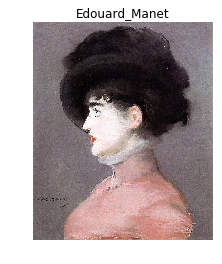

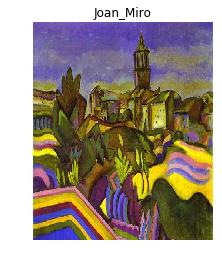

In [4]:
ori_image = load_img(ori_path,target_size=(ncol, nrow))
print(ori_image.size)
style_image = load_img(style_path, target_size=(ncol, nrow))
plt.axis('off')
plt.title('Edouard_Manet')
plt.imshow(ori_image)
plt.show()
plt.axis('off')
plt.title('Joan_Miro')
plt.imshow(style_image)

Pre-Process the images as the VGG16 input.Using tensor to represent the image,and bulid a new imgae as ouput

In [5]:
def preprocess(image):
    img = img_to_array(image)
    img = vgg16.preprocess_input(img[np.newaxis,:])
    img = K.variable(img)
    return img
ori_img = preprocess(ori_image)
style_img = preprocess(style_image)
result_image = K.placeholder((1,ncol, nrow,3)) # 'channels_last' format()
result_image.shape

Instructions for updating:
Colocations handled automatically by placer.


TensorShape([Dimension(1), Dimension(590), Dimension(486), Dimension(3)])

Then intergrating original image, style image and result image.

In [6]:
vgg16_input = K.concatenate([ori_img,style_img,result_image], axis=0)
vgg16_input

<tf.Tensor 'concat:0' shape=(3, 590, 486, 3) dtype=float32>

Import VGG16 model, and make a dictionary

In [7]:
model = vgg16.VGG16(input_tensor=vgg16_input,
                    weights='imagenet', include_top=False)
model.summary()
#dictionary
model_dict = dict([(layer.name, layer.output) for layer in model.layers])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (3, 590, 486, 3)          0         
_________________________________________________________________
block1_conv1 (Conv2D)        (3, 590, 486, 64)         1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (3, 590, 486, 64)         36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (3, 295, 243, 64)         0         
_________________________________________________________________
block2_conv1 (Conv2D)        (3, 295, 243, 128)        73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (3, 295, 243, 128)        147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (3, 147, 121, 128)        0         
__________

Check the dictionary

In [8]:
model_dict

{'block1_conv1': <tf.Tensor 'block1_conv1/Relu:0' shape=(3, 590, 486, 64) dtype=float32>,
 'block1_conv2': <tf.Tensor 'block1_conv2/Relu:0' shape=(3, 590, 486, 64) dtype=float32>,
 'block1_pool': <tf.Tensor 'block1_pool/MaxPool:0' shape=(3, 295, 243, 64) dtype=float32>,
 'block2_conv1': <tf.Tensor 'block2_conv1/Relu:0' shape=(3, 295, 243, 128) dtype=float32>,
 'block2_conv2': <tf.Tensor 'block2_conv2/Relu:0' shape=(3, 295, 243, 128) dtype=float32>,
 'block2_pool': <tf.Tensor 'block2_pool/MaxPool:0' shape=(3, 147, 121, 128) dtype=float32>,
 'block3_conv1': <tf.Tensor 'block3_conv1/Relu:0' shape=(3, 147, 121, 256) dtype=float32>,
 'block3_conv2': <tf.Tensor 'block3_conv2/Relu:0' shape=(3, 147, 121, 256) dtype=float32>,
 'block3_conv3': <tf.Tensor 'block3_conv3/Relu:0' shape=(3, 147, 121, 256) dtype=float32>,
 'block3_pool': <tf.Tensor 'block3_pool/MaxPool:0' shape=(3, 73, 60, 256) dtype=float32>,
 'block4_conv1': <tf.Tensor 'block4_conv1/Relu:0' shape=(3, 73, 60, 512) dtype=float32>,
 'b

Vgg16 is usually used to classificate, however, here we need to delete the classification purpose layyers.

In this case, we decided to use 6 convolution layers to get the image's feature and one layers as output style feature

In [9]:
# 6 convolution layers and one output style feature
feature_layers = ['block1_conv1','block1_conv2',
                'block2_conv1','block3_conv1', 
               'block4_conv1','block5_conv1']
nfeature_layer = 6
output_layers = ['block5_conv2'] 

Using dictionary and layers we choosed late step to gerenate features

In [10]:
features = model_dict['block5_conv2']
ori_features = features[0, :, :, :]
new_features = features[2, :, :, :]

We need a optimizer to minimize the loss between stype image and new image. After reading the "Optimizers Guide"(https://qiskit.org/documentation/aqua/optimizers.html), we decided to use the Limited-memory Broyden-Fletcher-Goldfarb-Shanno Bound, because this optimizer has a direct callable function by scipy (https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.fmin_l_bfgs_b.html)

In [11]:
from scipy.optimize import fmin_l_bfgs_b
# x, f, d= fmin_l_bfgs_b(func, x0)

# x : array_like(Estimated position of the minimum.)
# f : float(Value of func at the minimum.)
# d : dict(Information dictionary.)
# func : callable f(x,*args) Function to minimise.
# x0 : ndarray Initial guess.

Here we decided to use the error square as loss and gradients descent which we learned in lecture.

Define Output Loss Function, using error square
(keras.backend.square(x) https://keras.io/backend/)

In [12]:
# we has total 7 layers, the last ouput layer get smallest weight
output_weight=0.03
output_loss = output_weight * K.sum(K.square(new_features - ori_features))

Define Style Loss Function, using Gram Matrices

A Gram matrix of vectors a1, ... ,an is a matrix G

s.t. G=⟨ai,aj⟩ for all i,j
if vectors a1, ... ,an are columns of a matrix A, then
G=ATA
a Gram matrix is Positive Definite and Symmetric
if vectors a1, ... ,an are the rows of A (A would be so-called "Data Matrix"), then G=AAT, and it's called left Gram matrix

Then still using error square to caclutate 2 matrices loss

In [13]:
def style_loss_function(style_features, new_features):
    #overturn style_features tensor 
    style_features = tensorflow.reshape(style_features, 
                                        [-1, style_features.shape[-1]])
    # G=AAT
    style_gram_mtr = tensorflow.matmul(style_features, style_features,
                                       transpose_a=True,transpose_b=False)
    new_features = tensorflow.reshape(new_features, 
                                        [-1, style_features.shape[-1]])
    # G=AAT
    output_gram_mtr = tensorflow.matmul(new_features, new_features,
                                       transpose_a=True,transpose_b=False)
    # Error square to caclutate 2 matrices loss
    style_loss = K.sum(K.square(style_gram_mtr - output_gram_mtr))
    return style_loss

Define How to Caculate the initial gradients, uising
keras.backend.gradients(loss, variables) https://keras.io/backend/#gradients

In [14]:
for layer_name in feature_layers:
    features = model_dict[layer_name]
    style_features = features[1, :, :, :]
    new_features = features[2, :, :, :]
    style_loss = style_loss_function(style_features, new_features)
    # 1 output layer, 6 convolution layers(features)
    output_loss = output_loss + (1 / nfeature_layer) * style_loss
gradient = K.gradients(output_loss, result_image)
loss_list = [output_loss]
loss_list += gradient #Record gradient
keras_function = K.function([result_image], loss_list)

With loss function and initial gradients, now we define the callable function to minimise using in optimizer.

In [15]:
class func(object):
    def __init__(self):
        self.loss_value = None

    def loss(self, x):
        x = x.reshape((1, ncol, nrow, 3))
        result = keras_function([x])
        self.loss_value = result[0]
        self.grad_values = np.array(result[1:]).flatten().astype('float64')
        return self.loss_value

    def grad(self, x):
        grad_values = np.copy(self.grad_values)
        self.loss_value = None
        self.grad_values = None
        return grad_values
function = func()

Using original image as the input

In [16]:
# run scipy-based optimization (L-BFGS) over the pixels of the generated image
# so as to minimize the neural style loss
X = load_img(ori_path, target_size=(ncol, nrow))
X = np.expand_dims(img_to_array(X), axis=0)
X = vgg16.preprocess_input(X)

Start iterating using Limited-memory Broyden-Fletcher-Goldfarb-Shanno Bound

In [17]:
nitr = 400
neval = 20 #Maximum number of function evaluations.
loss = []
for i in range(nitr):
    print('Iteration = {}'.format(i))
    if i == 0:
        opt_loss = float('Inf') #initial min loss
    X, func_min, d= fmin_l_bfgs_b(function.loss, X.flatten(), fprime=function.grad, maxfun = neval)
    loss.append(func_min)
    print(d['grad'])
    if func_min < opt_loss:
        opt_loss = func_min
        opt_X = X.copy()

Iteration = 0
[-1.13819259e+14  2.11088499e+13  7.24103636e+13 ...  5.96972038e+12
  1.85995991e+13  1.44182818e+12]
Iteration = 1
[ 9.70059153e+12  1.30129005e+13  1.63229123e+10 ...  4.57716374e+12
 -6.35074773e+12 -1.16962584e+12]
Iteration = 2
[-7.88490564e+13 -6.56955681e+13 -6.55839828e+13 ...  1.81990851e+12
 -6.15783072e+12 -9.84203788e+11]
Iteration = 3
[-5.32359309e+12  2.57250443e+13  1.50716348e+13 ...  1.94227130e+12
  4.34667520e+09 -1.62685688e+12]
Iteration = 4
[-7.81255893e+13 -6.35482690e+13 -9.43444428e+13 ...  3.86211303e+12
 -1.52068869e+12 -1.64111424e+12]
Iteration = 5
[-1.63219086e+13 -1.65134074e+11 -9.60866497e+12 ...  2.12884980e+12
 -9.67161414e+11 -6.63994434e+11]
Iteration = 6
[-7.16098188e+12 -1.41737717e+13  1.39223840e+12 ...  1.12571344e+12
  1.03437330e+12  5.56085084e+11]
Iteration = 7
[ 6.73106231e+11  9.22526679e+12  9.06563473e+12 ...  5.53725329e+11
 -8.04967219e+11 -9.33747229e+11]
Iteration = 8
[-9.22146780e+12 -1.79231313e+13 -3.23967071e+12 .

[ 9.33855494e+11  1.43397290e+12  1.70309360e+12 ... -4.13023535e+11
 -3.92556970e+11 -4.23191839e+11]
Iteration = 71
[ 1.24093805e+12  2.36980797e+12  1.97195386e+12 ... -3.86846818e+11
 -5.83253819e+11 -4.25975742e+11]
Iteration = 72
[-6.01345491e+11 -4.81250836e+11  9.20665784e+10 ... -3.04272114e+11
 -2.51532673e+11 -2.20455535e+11]
Iteration = 73
[ 1.01170079e+12  1.73514241e+12  1.61706148e+12 ... -3.86726429e+11
 -5.59958524e+11 -3.99668576e+11]
Iteration = 74
[ 1.79406452e+12  2.25608781e+12  2.79264022e+12 ... -4.45103997e+11
 -3.46100466e+11 -3.89233967e+11]
Iteration = 75
[ 1.77163312e+12  2.27091887e+12  1.90260812e+12 ... -3.55049603e+11
 -5.03334109e+11 -4.01905811e+11]
Iteration = 76
[ 1.73558478e+12  2.65531320e+12  2.00612879e+12 ... -4.32251470e+11
 -3.91829586e+11 -4.77326082e+11]
Iteration = 77
[ 2.67374264e+11  4.37263401e+11  2.92059349e+11 ... -4.11925152e+11
 -5.84326250e+11 -4.80261112e+11]
Iteration = 78
[ 1.87556758e+11  9.19526310e+11  6.47964262e+11 ... -4.

[ 7.67793431e+11  9.80897956e+11  9.15511706e+11 ... -2.60726030e+11
 -3.34937555e+11 -2.93437112e+11]
Iteration = 141
[ 6.51381375e+11  1.10326042e+12  8.45583745e+11 ... -2.52271821e+11
 -4.46217585e+11 -3.28485732e+11]
Iteration = 142
[ 3.15658863e+11  6.61175206e+11  5.91371174e+11 ... -2.32188248e+11
 -3.78057818e+11 -3.50092067e+11]
Iteration = 143
[ 8.15822799e+11  1.16574467e+12  8.76795593e+11 ... -2.05407322e+11
 -3.84621806e+11 -2.53819650e+11]
Iteration = 144
[ 1.02298196e+12  1.02526484e+12  1.13355260e+12 ... -2.20291678e+11
 -3.16699673e+11 -3.25487329e+11]
Iteration = 145
[ 5.65040513e+11  4.52816601e+11  4.33242178e+11 ... -2.42873696e+11
 -3.60334950e+11 -2.86735106e+11]
Iteration = 146
[ 6.18015031e+11  1.10903545e+12  6.69577380e+11 ... -1.80255834e+11
 -2.40335585e+11 -2.33865724e+11]
Iteration = 147
[ 8.93745627e+11  9.58388568e+11  8.59377762e+11 ... -2.03527111e+11
 -2.94881526e+11 -2.13667643e+11]
Iteration = 148
[ 1.08217352e+11 -9.08354781e+11 -6.41565852e+11

[ 1.78015420e+11  5.00947763e+10  8.65899971e+10 ... -1.36375476e+11
 -2.24302727e+11 -1.87927822e+11]
Iteration = 210
[ 1.98566183e+11  4.52907565e+11  2.68790039e+11 ... -6.40385516e+10
 -6.58385756e+10 -2.68415762e+11]
Iteration = 211
[ 1.50671720e+11  1.54863960e+11  1.53915965e+11 ... -1.37140109e+11
 -2.54029087e+11 -1.62739110e+11]
Iteration = 212
[ 2.91883479e+10 -2.35916345e+11 -5.08216607e+10 ... -8.31668224e+10
 -1.17910733e+11 -1.67591772e+11]
Iteration = 213
[ 1.97304713e+11  3.30080977e+11  2.16298226e+11 ... -1.84611013e+11
 -2.72928342e+11 -2.26301886e+11]
Iteration = 214
[ 3.83405425e+10  5.96644905e+10  9.48385628e+10 ... -8.72874394e+10
 -1.33459673e+11 -2.09318707e+11]
Iteration = 215
[ 2.95448936e+11  3.79180941e+11  3.07391562e+11 ... -1.42209647e+11
 -2.28880531e+11 -2.18714145e+11]
Iteration = 216
[-2.08248963e+11 -6.91405980e+11 -4.37724185e+11 ... -1.80341146e+11
 -1.94558001e+11 -3.10009987e+11]
Iteration = 217
[ 2.33297560e+11  1.13140482e+11  1.32291256e+11

[ 1.96782756e+10  3.63733811e+09  3.19593595e+10 ... -1.31302441e+11
 -1.13582793e+11 -2.18288325e+11]
Iteration = 279
[ 1.99059702e+11  5.47880387e+10  1.02465569e+11 ... -9.98576947e+10
 -1.87586871e+11 -8.88716493e+10]
Iteration = 280
[-1.49106770e+11 -3.71139576e+11 -2.36270338e+11 ... -1.04712913e+11
 -6.90466406e+10 -1.70217882e+11]
Iteration = 281
[ 1.66985761e+11  9.73700219e+10  5.89775585e+10 ... -9.32379689e+10
 -1.46746737e+11 -7.97709517e+10]
Iteration = 282
[-6.82276413e+10 -3.81869031e+11 -3.36723804e+11 ... -1.16000276e+11
 -1.16007928e+11 -1.77057104e+11]
Iteration = 283
[ 1.91659745e+10  3.39882803e+10 -1.36827617e+10 ... -1.33596774e+11
 -1.95088187e+11 -1.69152938e+11]
Iteration = 284
[-1.24813967e+10 -2.90472854e+11 -2.00168325e+11 ... -8.47861268e+10
 -7.90294774e+10 -1.31384001e+11]
Iteration = 285
[ 9.31422208e+10 -6.99890156e+10 -2.62979748e+10 ... -1.21811567e+11
 -1.93272381e+11 -1.23927757e+11]
Iteration = 286
[-2.89100636e+10 -3.65867205e+11 -2.36622758e+11

[ 2.78255370e+11 -7.48132680e+10 -2.67719250e+10 ... -1.41631144e+11
 -2.57314685e+11 -7.32146729e+10]
Iteration = 348
[ 1.53828164e+11  6.28393984e+09  4.42471055e+10 ... -1.48901773e+11
 -1.31118514e+11 -1.71857101e+11]
Iteration = 349
[-4.39034388e+10 -4.39768515e+11 -1.94312765e+11 ... -7.75900283e+10
 -9.57515366e+10  5.59301591e+10]
Iteration = 350
[ 4.84950262e+10  2.42194964e+10  6.00478228e+10 ... -1.29562141e+11
 -1.30042151e+11 -1.63298083e+11]
Iteration = 351
[ 9.98867190e+10 -9.88626043e+10 -3.74519644e+10 ... -1.09157532e+11
 -1.59587942e+11 -5.09655327e+10]
Iteration = 352
[ 2.17702793e+11  5.09393715e+09  1.29481220e+11 ... -1.03602733e+11
 -1.91583560e+10 -1.41553992e+11]
Iteration = 353
[ 2.70318920e+10  7.75009321e+10 -2.02997760e+08 ... -1.42824800e+11
 -1.89166944e+11 -1.21913721e+11]
Iteration = 354
[ 5.20396022e+10 -1.54670858e+11 -9.35124992e+10 ... -1.24605800e+11
 -1.09616734e+11 -1.71504665e+11]
Iteration = 355
[-3.46296484e+10 -1.54107593e+11 -1.46180391e+11

Plot the minimum loss each iteration.

Text(0, 0.5, 'loss')

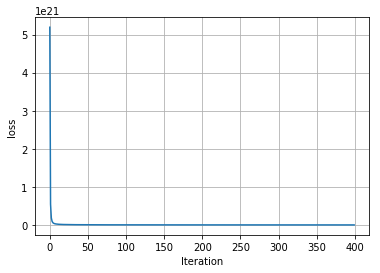

In [18]:
plt.plot(loss)
plt.grid()
plt.xlabel('Iteration')
plt.ylabel('loss')

Then convert output array to image.

VGG-16  was trained using Caffe, and Caffe uses OpenCV to load images which uses BGR by default, so both VGG models are expecting BGR images.

The official mean that gets used in the vgg16.py  file is [123.68, 116.779, 103.939] (https://forums.fast.ai/t/how-is-vgg16-mean-calculated/4577/9)

So we need to covert BGR to RGB before imshow

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


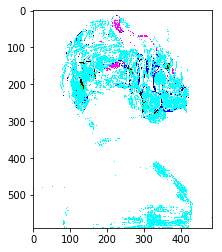

In [19]:
opt_X = opt_X.reshape((ncol, nrow,  3))
vgg_mean = [103.939,116.779,123.68]
for i in range(3):
    opt_X[:, :, i] = opt_X[:, :, i] + vgg_mean[i]
plt.imshow(opt_X)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


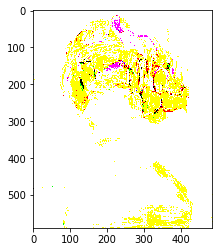

In [20]:
opt_X = opt_X[:, :, ::-1]
opt_X = np.clip(opt_X, 0, 255)
plt.imshow(opt_X)

Convert the numpy arrays to uint8 before passing them to Image.fromarray

np array should have data type as uint8

(https://stackoverflow.com/questions/10443295/combine-3-separate-numpy-arrays-to-an-rgb-image-in-python)

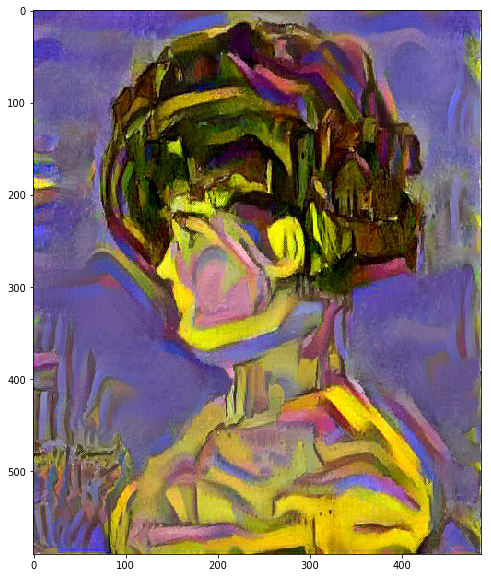

In [21]:
opt_X = opt_X.astype('uint8')
plt.figure(figsize=(10,10))
plt.imshow(opt_X)

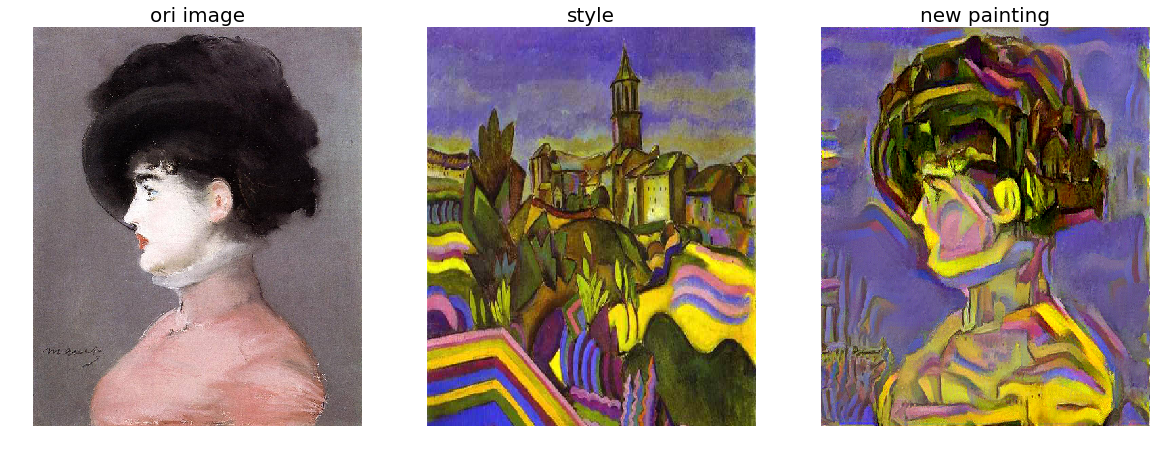

In [22]:
# Ori
plt.figure(figsize=(20,20))
plt.subplot(1,3,1)
plt.title("ori image",fontsize=20)
plt.axis('off')
plt.imshow(ori_image)
# style
plt.subplot(1,3,2)
plt.title("style",fontsize=20)
img_style = load_img(style_path)
plt.axis('off')
plt.imshow(style_image)
# new painting
plt.subplot(1,3,3)
plt.title("new painting",fontsize=20)
plt.axis('off')
plt.imshow(opt_X)